# Table of Contents
 <p><div class="lev1 toc-item"><a href="#DSSM-or-Deep-Structured-Semantic-Models" data-toc-modified-id="DSSM-or-Deep-Structured-Semantic-Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>DSSM or Deep Structured Semantic Models</a></div><div class="lev1 toc-item"><a href="#Preparation" data-toc-modified-id="Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparation</a></div><div class="lev1 toc-item"><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></div><div class="lev2 toc-item"><a href="#EDA" data-toc-modified-id="EDA-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>EDA</a></div><div class="lev2 toc-item"><a href="#Crawling-data" data-toc-modified-id="Crawling-data-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Crawling data</a></div><div class="lev2 toc-item"><a href="#Preprocessing" data-toc-modified-id="Preprocessing-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Preprocessing</a></div><div class="lev1 toc-item"><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model</a></div><div class="lev2 toc-item"><a href="#Architecture" data-toc-modified-id="Architecture-41"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Architecture</a></div><div class="lev2 toc-item"><a href="#Loss" data-toc-modified-id="Loss-42"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Loss</a></div><div class="lev2 toc-item"><a href="#Train" data-toc-modified-id="Train-43"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Train</a></div><div class="lev2 toc-item"><a href="#Load" data-toc-modified-id="Load-44"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Load</a></div><div class="lev2 toc-item"><a href="#Validate" data-toc-modified-id="Validate-45"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Validate</a></div><div class="lev1 toc-item"><a href="#Interactive-test" data-toc-modified-id="Interactive-test-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Interactive test</a></div>

# DSSM or Deep Structured Semantic Models

In this notebook we're going to build an information retrieval model for question answering task. For that purpose we will use so called **Deep Structured Semantic Model** or **DSSM**. This model was first [introduced](https://www.microsoft.com/en-us/research/publication/learning-deep-structured-semantic-models-for-web-search-using-clickthrough-data/) by the Microsoft team. One can also find more papers from the creators of the DSSM [here](https://www.microsoft.com/en-us/research/project/dssm/).

Below we will cover the following things:
* How to download and preprocess Q&A corpus for the model
* What is DSSM and how it works
* Triplet objective function and negative sampling for training DSSM
* Working prototype of the system

# Preparation

Import libraries

In [1]:
import os
import json
import pickle
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf

import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Dense, Lambda, LSTM
from keras.layers.pooling import _GlobalPooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import get_file

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

Using TensorFlow backend.


Set style for plotting

In [2]:
sns.set(style="whitegrid", font_scale=1.3)

matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True
matplotlib.rcParams["legend.fontsize"] = 14

matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["font.size"] = 14

matplotlib.rcParams["xtick.labelsize"] = 14
matplotlib.rcParams["ytick.labelsize"] = 14

matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 20

Fix seed for reproducibility

In [3]:
np.random.seed(42)

# Data

In this task we use Stanford Question Answering Dataset [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/).

It has about 100.000 question-answer pairs. Let's download it

In [4]:
get_file("train.json", "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json", cache_dir="./", cache_subdir="./")
print()
get_file("dev.json", "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json", cache_dir="./", cache_subdir="./");

4489216/4854279 [==========================>...] - ETA: 0s

## EDA

Let's look at the data using development set.

In [5]:
data = json.load(open("./dev.json"))["data"]

The dataset structured in the following way. First of all, there are *topics*. These are big groups of questions united by the common theme.

In [6]:
print("Number of topics in dev set = {:d}".format(len(data)))

Number of topics in dev set = 48


Examples of topics

In [7]:
[topic["title"] for topic in data[:5]]

['Super_Bowl_50',
 'Warsaw',
 'Normans',
 'Nikola_Tesla',
 'Computational_complexity_theory']

Let's take first topic and explore it further.

In [8]:
data[0].keys()

dict_keys(['title', 'paragraphs'])

Inside the topic there are *paragraphs* $-$ pieces of text that contain the information and the questions based on it.

In [9]:
print("Number of the paragraphs in the first topic = {:d}".format(len(data[0]["paragraphs"])))

Number of the paragraphs in the first topic = 54


For example, the topic "Super_Bowl_50" has 54 paragraphs. Each paragraph looks the following

In [10]:
data[0]["paragraphs"][0].keys()

dict_keys(['context', 'qas'])

It has a *context* which is a body of the paragraph.

In [11]:
data[0]["paragraphs"][0]["context"]

'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.'

And it also has *Q&A pairs* related to the context.

In [12]:
print("Number of the Q&A pairs for the first paragraph in the first topic = {:d}".format(len(data[0]["paragraphs"][0]["qas"])))

Number of the Q&A pairs for the first paragraph in the first topic = 30


Example of the Q&A pair

In [13]:
data[0]["paragraphs"][0]["qas"][0]

{'answers': [{'answer_start': 177, 'text': 'Denver Broncos'},
  {'answer_start': 177, 'text': 'Denver Broncos'},
  {'answer_start': 177, 'text': 'Denver Broncos'}],
 'id': '56be4db0acb8001400a502ec',
 'question': 'Which NFL team represented the AFC at Super Bowl 50?'}

Release memory as it will be crucial later

In [14]:
%xdel data

## Crawling data

In this notebook we're going to completely ignore the contexts of the quesitions. We need only pairs in the form of "Question - Answer".

For that purpose let's iterate over all topics and all paragraphs inside them and extract only Q&A pairs

In [15]:
def parse_json(filename):
    data = json.load(open(filename))
    questions = []
    answers = []
    for topic in data["data"]:
        for paragraph in topic["paragraphs"]:
            for qa in paragraph["qas"]:
                questions.append(qa["question"])
                answers.append(qa["answers"][0]["text"])
    return np.array(questions), np.array(answers)

Parse both train and development sets

In [16]:
_data1 = parse_json("./train.json")
_data2 = parse_json("./dev.json")

Join traind and dev sets

In [17]:
questions = np.append(_data1[0], _data2[0])
answers = np.append(_data1[1], _data2[1])

Release memory

In [18]:
%xdel _data1
%xdel _data2

Let's see what are the examples of the crawled data

In [19]:
questions[:5]

array(['To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
       'What is in front of the Notre Dame Main Building?',
       'The Basilica of the Sacred heart at Notre Dame is beside to which structure?',
       'What is the Grotto at Notre Dame?',
       'What sits on top of the Main Building at Notre Dame?'], 
      dtype='<U25651')

In [20]:
answers[:5]

array(['Saint Bernadette Soubirous', 'a copper statue of Christ',
       'the Main Building', 'a Marian place of prayer and reflection',
       'a golden statue of the Virgin Mary'], 
      dtype='<U239')

## Preprocessing

The next step after retrieving the data is preprocessing.

First of all, let's divide our data into train and validation sets. Here we prefer to get the indices for this split because in that way it will be easier to carry out the preprocessing in terms of coding $-$ the preprocessing steps are the same for both train and validation sets.

In [21]:
idxs_train, idxs_valid = train_test_split(np.arange(len(questions)), 
                                          random_state=21, test_size=0.1)

Let's filter out specific symbols such as punctuations etc. It can be done with `text_to_word_sequence` utility function from Keras. It also puts all the symbols into lowercase

At the same time we want to transform all the numbers into the unique token $<num>$

In [22]:
questions_processed = []
answers_processed = []
for i in range(len(answers)):
    # text_to_word_sequence deletes all symbols from the '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    # and then return individual words from sentencs. After that we join them with spaces
    q = " ".join([w if not w.isdigit() else "<num>" for w in text_to_word_sequence(questions[i])])
    a = " ".join([w if not w.isdigit() else "<num>" for w in text_to_word_sequence(answers[i])])
    # append to the dataset
    questions_processed.append(q)
    answers_processed.append(a)
questions_processed = np.array(questions_processed)
answers_processed = np.array(answers_processed)

Let's see how preprocessing works

In [23]:
questions[14188]

'How many slaves were on the island in 1723?'

In [24]:
questions_processed[14188]

'how many slaves were on the island in <num>'

In [25]:
answers[14188]

'610'

In [26]:
answers_processed[14188]

'<num>'

Indeed, it works as we anticipated $-$ there are no punctuation (question mark is gone), no upper case and no numbers.

The next step is to *tokenize* the data. Tokenization process basically consists of two steps:
* Create a vocabulary of words that are used in the text corpus
* Converte words into numbers which corresponds to the place in the vocabulary

All these steps can be done with Keras class `Tokenizer`. Note that we set filter to empty string because we filtered out all the sentences before.

In [27]:
tk = Tokenizer(filters="")

Let's fit our tokenizer **only on the train set**. It is crucial because during the test stage we might have new words that are absent in the vocabulary. Thus to be able to consistently estimate the performance of the model using validation set we should not include validation set into the vocabulary.

In [28]:
tk.fit_on_texts(np.append(questions_processed[idxs_train], answers_processed[idxs_train]))

See some simple statistics on the vocabulary

In [29]:
number_of_words = len(tk.word_counts)
print("Number of words in the vocabulary = {:d}".format(number_of_words))

Number of words in the vocabulary = 55211


Most common words

In [30]:
Counter(tk.word_counts).most_common(10)

[('the', 81007),
 ('what', 51116),
 ('of', 43615),
 ('<num>', 33148),
 ('in', 29524),
 ('to', 22713),
 ('was', 17918),
 ('is', 17571),
 ('did', 16111),
 ('and', 15695)]

Let's tokenize both train and validation set. New words in the validation set that are not on the vocabulary will be thrown away.

In [31]:
questions_tokenized = tk.texts_to_sequences(questions_processed)
answers_tokenized = tk.texts_to_sequences(answers_processed)

Note that token numeration **starts with 1**. It is important because place number 0 in the vocabulary is reserved for the **padding** which will be discussed few lines below.

In [32]:
questions_tokenized[:5]

[[6, 288, 9, 1, 2293, 690, 7583, 790, 5, 4, 5, 17628, 174],
 [2, 8, 5, 1544, 3, 1, 558, 559, 164, 234],
 [1, 3567, 3, 1, 3064, 1456, 34, 558, 559, 8, 5912, 6, 16, 699],
 [2, 8, 1, 21962, 34, 558, 559],
 [2, 9185, 19, 363, 3, 1, 164, 234, 34, 558, 559]]

In [33]:
answers_tokenized[:5]

[[466, 42712, 42713],
 [11, 746, 4639, 3, 1795],
 [1, 164, 234],
 [11, 8547, 130, 3, 3045, 10, 5976],
 [11, 1633, 4639, 3, 1, 2293, 690]]

Let's see how the lengths of the sentences are distributed

In [34]:
question_lenghts = np.array(list(map(lambda x: len(x), questions_tokenized)))
answer_lenghts = np.array(list(map(lambda x: len(x), answers_tokenized)))

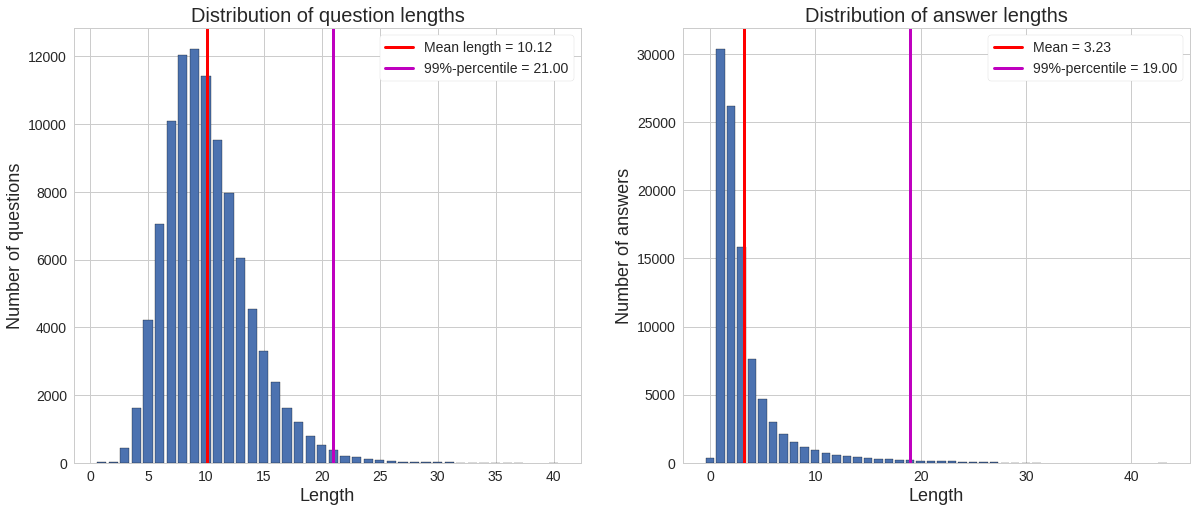

In [35]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.bar(*np.unique(question_lenghts, return_counts=True), edgecolor="k")
plt.axvline(np.mean(question_lenghts), 
            c="r", lw=3, 
            label="Mean length = {:.2f}".format(np.mean(question_lenghts)))
plt.axvline(np.percentile(question_lenghts, 99), 
            c="m", lw=3, 
            label="99%-percentile = {:.2f}".format(np.percentile(question_lenghts, 99)))
plt.xlabel("Length")
plt.ylabel("Number of questions")
plt.title("Distribution of question lengths")
plt.legend()

plt.subplot(122)
plt.bar(*np.unique(answer_lenghts, return_counts=True), edgecolor="k")
plt.axvline(np.mean(answer_lenghts), 
            c="r", lw=3, 
            label="Mean = {:.2f}".format(np.mean(answer_lenghts)))
plt.axvline(np.percentile(answer_lenghts, 99), 
            c="m", lw=3, 
            label="99%-percentile = {:.2f}".format(np.percentile(answer_lenghts, 99)))
plt.xlabel("Length")
plt.ylabel("Number of answers")
plt.title("Distribution of answer lengths")
plt.legend();

To be able to feed tokenized sentences into the model we should force them to have equal length. This is the restriction of the Keras and TensorFlow frameworks $-$ input should be a *tensor* and tensor should have equal length of the objects containing in it.

Based on the distribution we decidede to set this length to 21. It means that all the longer sentences will be cut to fit the length and all the shorter sentences will be padded with zeros. Recall that 0 is a special token in the vocabulary that represents the absent of any word.

In [36]:
cut_length = 21

In [37]:
questions_padded = pad_sequences(questions_tokenized, maxlen=cut_length)
answers_padded = pad_sequences(answers_tokenized, maxlen=cut_length)

The final form of the processed texts:

In [38]:
questions_padded

array([[    0,     0,     0, ...,     5, 17628,   174],
       [    0,     0,     0, ...,   559,   164,   234],
       [    0,     0,     0, ...,     6,    16,   699],
       ..., 
       [    0,     0,     0, ...,     1,  5936,    65],
       [    0,     0,     0, ...,   138,     3,   206],
       [    0,     0,     0, ...,    45,  2770, 30517]], dtype=int32)

As long as we are ready with the preprocessing steps let's divide our Q&A pairs into train and validation sets using indices generated above.

In [39]:
q_train, q_valid = questions_padded[idxs_train], questions_padded[idxs_valid]
a_train, a_valid = answers_padded[idxs_train], answers_padded[idxs_valid]

Number of examples in each of the sets:

In [40]:
print("Number of train pairs = {:d}".format(len(q_train)))
print("Number of valid pairs = {:d}".format(len(q_valid)))

Number of train pairs = 88352
Number of valid pairs = 9817


# Model

Below we build, train and validate DSSM model for question answering

## Architecture

In this part we build simple DSSM model with two **towers**. First tower is for encoding of the questions and second is for encoding of the answers.

We start with the input layers (one for questions and one for answers) which accept the sequences of the token numbers with the length of 21.

In [41]:
q_input = Input(shape=(cut_length,), 
                dtype="int32", 
                name="QInput")
a_input = Input(shape=(cut_length,), 
                dtype="int32", 
                name="AInput")

Next step is to do an **Embedding**. See `EmbeddingsReuters` or `EmbeddingsExploration` for more details on the embeddings. The general idea is to embed the words into low dimensional space which will preserve the semantic relation among them.

In practive embedding layer is just a lookup table where for each token number we have low dimensional (in this case 100) vector. These vectors are learnt through the task which is called **co-training**. The other option might be to use pre-trained embeddings.

Here we also set `mask_zero` option to `True`. It means that Embedding layer will create and pass to the deeper layers a mask which shows where the input is real and where it was padded with zeros.

In [42]:
_embedding_layer = Embedding(input_dim=number_of_words + 1,
                             output_dim=100,
                             input_length=cut_length,
                             trainable=True,
                             mask_zero=True, 
                             name="Embedding")

Important note here is that we **share** the embeddings between questions and answers. It means we use the same embeddings for both questions and answers. The other option might be to use individual embeddings for questions and answers.

In [43]:
q_embeddeding = _embedding_layer(q_input)
a_embeddeding = _embedding_layer(a_input)

The following step is to encode the embedded sequence of words into something more meaningful. Here we're using `LSTM` layer for that.

In fact, this is the main field for the experiments in modern science. Improving the **encoder** is the goal of many state-of-the-art papers. For example, right now the best encoder for texts might be [attention ecnoder](https://arxiv.org/pdf/1706.03762.pdf) suggested by Google. There are also [convolutional encoders](https://arxiv.org/pdf/1705.03122.pdf) that works pretty well. Interestingly, LSTMs are out-of-the-trend now because they are heavy and the architecture is consecutive in its nature. While with convolutions and attention one can encode all the sentence simultaneously.

In [44]:
q_rnn = LSTM(64, return_sequences=True, name="QLSTM")(q_embeddeding)
a_rnn = LSTM(64, return_sequences=True, name="ALSTM")(a_embeddeding)

Note that previous LSTM layers return sequences of vectors with the dimension of 64. The next step of our encoder is to aggregate this sequence.

Below we define two function for aggregation that are able to work with masked inputs (see `EmbeddingsReuters` notebook for more details):
* **Global Average Pooling** takes an average value across all the steps of the sequence that are real using input mask
* **Global Max Pooling** takes a max value across all the steps of the sequence

In [45]:
class MaskedGlobalAveragePooling1D(_GlobalPooling1D):
    
    def __init__(self, **kwargs):
        self.support_mask = True
        super(MaskedGlobalAveragePooling1D, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaskedGlobalAveragePooling1D, self).build(input_shape)
        self.feat_dim = input_shape[2]

    def call(self, x, mask=None):
        if mask is not None:
            mask = K.cast(mask, 'float32')
            n = K.sum(mask, axis=-1, keepdims=True)
            n += K.ones_like(n) * K.cast(K.equal(n, 0.0), 'float32')
            ans = K.sum(x, axis=1) / n
        else:
            ans = K.mean(x, axis=1)
        
        return ans

    def compute_mask(self, input_shape, input_mask=None):
        return None

In [46]:
class MaskedGlobalMaxPooling1D(_GlobalPooling1D):
    
    def __init__(self, **kwargs):
        self.support_mask = True
        super(MaskedGlobalMaxPooling1D, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaskedGlobalMaxPooling1D, self).build(input_shape)
        self.feat_dim = input_shape[2]

    def call(self, x, mask=None):
        ans = K.max(x, axis=1)
        return ans

    def compute_mask(self, input_shape, input_mask=None):
        return None

Here we choose to use max pooling.

In [47]:
q_max = MaskedGlobalMaxPooling1D(name="QGMP")(q_rnn)
a_max = MaskedGlobalMaxPooling1D(name="AGMP")(a_rnn)

After global pooling layers we have one vector for question and one vector for answer.

Next we want to normalize these vectors such that both of them have unit L2 norm. The purpose of this step is to be able to compute cosine distance later on as a simple dot product between vectors.

In [48]:
def L2_norm(x):
    return K.l2_normalize(x, axis=1)

In [49]:
q_normalized = Lambda(function=L2_norm, name="QL2norm")(q_max)
a_normalized = Lambda(function=L2_norm, name="AL2norm")(a_max)

## Loss

One of the most important and at the same time the most tricky parts of DSSMs is loss function.

Here we use **triplet loss**. It was first introduce in [this](https://arxiv.org/pdf/1503.03832.pdf) paper by Google.
![image.png](tripletloss1.png)

The idea of the triplet loss is shown in the image above which is taken from the referenced article.

In our case we have a question (which is *anchor*) and a correct answer (which is *positive*). But without the knowledge of what is the bad answers we can learn nothing good. Thus we take one example of the wrong (*negative*) answer which is not suitable for the given question. The goal of the triplet loss is to make encoders learn such transformations that map positive examples closer to the anchor than negative. This is also called [**metric learning**](https://en.wikipedia.org/wiki/Similarity_learning#Metric_learning).

In mathematical terms triplet loss looks the following:
$$
L(a, p, n) = \left[ D_{ap} ^ 2 - D_{an} ^ 2 + \alpha \right]_+\\
\text{where:}\\
f(x) \text{ - embedding function}\\
D_{ap} = \left\Vert f(a) - f(p)\right\Vert_2 \text{ - distance between anchor and positive}\\
D_{ap} = \left\Vert f(a) - f(n)\right\Vert_2 \text{ - distance between anchor and negative}\\
\alpha \text{ - margin}
$$
![image.png](tripletloss2.png)

In the image above the dependency of loss on pairwise distance is shown. The solid blue line shows the loss function for positive pairs, the dotted green for negative pairs.

One of the most important problems with triplet loss is how to choose negative examples. There are number of strategies the great comparison of which can be found in this [paper](https://arxiv.org/abs/1706.07567):
* **Easy negatives sampling** - take a random example from batch as a negative example. We will use this strategy as the simplest one. But other strategies consistently outperform easy negatives.
* **Hard negatives sampling** - take an example from the batch that is closest to the anchor. 
* **Semi-hard negatives sampling** - take an example that is closest to the anchor among examples that are farther than the positive.
* **Distance-based negative sampling** - randomly sample from the multinomial distribution with probabilities that are proportional to the disntace to the anchor.

Below there is a tensorflow implementation of the triplet loss with easy negatives sampling.

In [50]:
def triplet_loss(args):
    
    q, a = args
    
    def _get_probs():
        # easy negative sampling, i.e. take random from batch
        batch_size = tf.shape(a)[0]
        probs = tf.ones((batch_size, batch_size)) - tf.eye(batch_size, batch_size)
        return probs
    
    def _get_distance(batch1, batch2):
        return 1 - tf.reduce_sum(tf.multiply(batch1, batch2), axis=1)
    
    # margin
    alpha = 0.2
    
    # negative sampling
    probs = _get_probs()
    probs /= tf.reduce_sum(probs, axis=1)
    
    negative_idxs = tf.multinomial(tf.log(probs), 1)
    negs = tf.gather(a, negative_idxs)[:, 0]
    
    # distance calculation
    Dn = _get_distance(q, negs)
    Dp = _get_distance(q, a)
    
    # loss
    loss = tf.reduce_mean(tf.maximum(0.0, Dp - Dn + alpha))
    
    return loss

This objective function does not comply with the Keras rules for the objectives. Thus we need to implement it in the `Lambda` layer (see `CTC_CAPTCHA` notebook for more details and example).

In [51]:
loss_layer = Lambda(function=triplet_loss, name="Loss")([q_normalized, a_normalized])

Now we are ready to build a model

In [52]:
model = Model(inputs=[q_input, a_input], outputs=[loss_layer])

We're calculating loss function in the Lambda layer thus the loss function for the Keras compilation should just pass the value of the objective calculated before.

In [53]:
def dummy_loss(y_true, y_pred):
    return y_pred

Compile the model

In [54]:
model.compile(loss=dummy_loss, optimizer="Adam")

See what it is

In [55]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
QInput (InputLayer)              (None, 21)            0                                            
____________________________________________________________________________________________________
AInput (InputLayer)              (None, 21)            0                                            
____________________________________________________________________________________________________
Embedding (Embedding)            (None, 21, 100)       5521200     QInput[0][0]                     
                                                                   AInput[0][0]                     
____________________________________________________________________________________________________
QLSTM (LSTM)                     (None, 21, 64)        42240       Embedding[0][0]         

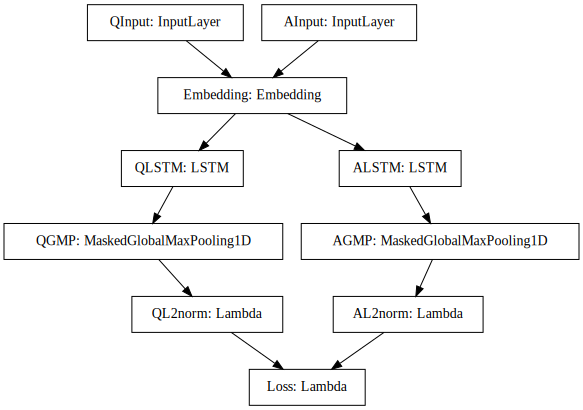

In [56]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Train

*You can consider to skip this section if you have already trained the model.*

Let's finally train DSSM model. Note that the $y$ values here are just zeros because with the loss function computed in Lambda layer we do not really need $y$.

In [57]:
hist = model.fit([q_train, a_train], np.zeros(q_train.shape[0]), 
                 validation_data=([q_valid, a_valid], np.zeros(q_valid.shape[0])), 
                 epochs=10, batch_size=128)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 88352 samples, validate on 9817 samples
Epoch 1/10
88352/88352 [==============================] - 56s - loss: 0.1203 - val_loss: 0.1059
Epoch 2/10
88352/88352 [==============================] - 56s - loss: 0.0692 - val_loss: 0.0952
Epoch 3/10
88352/88352 [==============================] - 57s - loss: 0.0495 - val_loss: 0.0886
Epoch 4/10
88352/88352 [==============================] - 56s - loss: 0.0402 - val_loss: 0.0866
Epoch 5/10
88352/88352 [==============================] - 57s - loss: 0.0342 - val_loss: 0.0839
Epoch 6/10
88352/88352 [==============================] - 57s - loss: 0.0303 - val_loss: 0.0842
Epoch 7/10
88352/88352 [==============================] - 56s - loss: 0.0271 - val_loss: 0.0849
Epoch 8/10
88352/88352 [==============================] - 56s - loss: 0.0253 - val_loss: 0.0817
Epoch 9/10
88352/88352 [==============================] - 56s - loss: 0.0228 - val_loss: 0.0833
Epoch 10/10
88352/88352 [==============================] - 56s - loss: 0.0217 - val_los

Save fitted model and training history for further usage.

In [58]:
model.save("./rnn.model")
pickle.dump(hist.history, open("./rnn.hist", "wb"))

## Load

Load already trained model. Note that due to the usage of custom (`MaskedGlobalMaxPooling1D`) and Lambda (`L2_norm`) layers and we should pass some additional parameters to the Keras model loader

In [59]:
model = load_model("./rnn.model", custom_objects={"MaskedGlobalMaxPooling1D": MaskedGlobalMaxPooling1D, 
                                                  "tf": tf, 
                                                  "dummy_loss": dummy_loss})
hist = pickle.load(open("./rnn.hist", "rb"))

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Validate

Let's see how the training procedure was carried out.

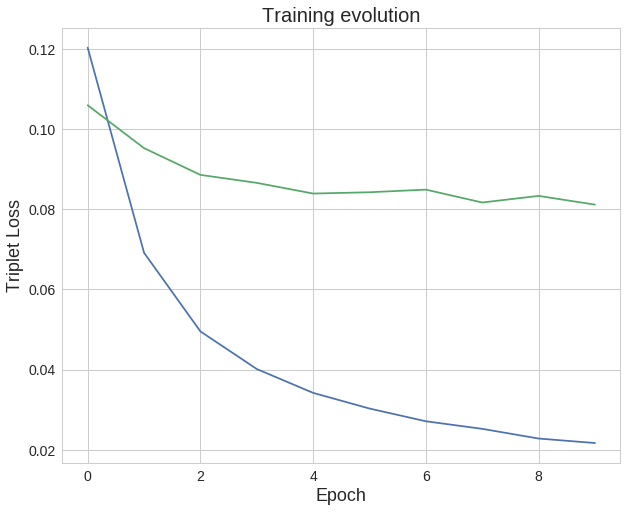

In [60]:
plt.plot(hist["loss"], label="Train")
plt.plot(hist["val_loss"], label="Validtion")
plt.xlabel("Epoch")
plt.ylabel("Triplet Loss")
plt.title("Training evolution");

Recall that DSSM model has **two towers** $-$ one is for question encoding and the other is for answer encoding. We train them together using triplet loss. But for the testing purposes we will separate towers and use them independently to encode the question and to find the most appropriate answer.

In [61]:
q_model = Model(inputs=[model.get_layer("QInput").input], 
                outputs=[model.get_layer("QL2norm").output])
a_model = Model(inputs=[model.get_layer("AInput").input], 
                outputs=[model.get_layer("AL2norm").output])

Now let's encode all the possible answers. Later on when the new question arrives we will ecnode it using corresponding tower and then find the most suitable answer among encoded training answers. With this approach the set of the asnwers is limited to the set of training answers.

Here we want to notice that there might be different approaches such as:
* Purely **generative** approach when one generates the answer on word-by-word basis
* [**Mixed**](https://arxiv.org/pdf/1610.07149.pdf) approach when one uses an ensemle of retrieval and generative models. For example, one might consider to sample 10 best answers from the retrieval model and then generate a new answer based on these top-10 retrieved answers as well as the initial sentence.

In [62]:
%%time
a_train_encoded = a_model.predict(a_train)

CPU times: user 2min 12s, sys: 26.2 s, total: 2min 38s
Wall time: 51.5 s


Once all the answers are encoded the next step is to fit the nearest neighbors model to be able to search the best suitable answer fast.

In this task our dataset contains only about 100k example and this number is relatively small. Thus we can apply exact methods for finding the nearest neighbors. Here we use [KD-tree](https://en.wikipedia.org/wiki/K-d_tree) implementation from `scikit-learn`. By default we want to crawl 5 nearest neighbors but it can be changed later when predicting the neigbors. We also use L2 metric as a measure of distance between objects.

In case if there are much more examples one can consider to use approximate algorithms for finding nearest neighbors such as [HNSW](https://arxiv.org/abs/1603.09320) or some other.

In [63]:
nn = NearestNeighbors(n_neighbors=5, metric="minkowski", p=2, n_jobs=-1, algorithm="kd_tree")

Fit nearest neighbors model on encoded train answers

In [64]:
nn.fit(a_train_encoded)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

Now we want to see how well our model can perform on the hold-out data.

For that purpose let's encode all the validation questions using corresponding tower of DSSM.

In [65]:
%%time
q_valid_encoded = q_model.predict(q_valid)

CPU times: user 15.6 s, sys: 2.74 s, total: 18.3 s
Wall time: 6.2 s


Once the questions are encoded we need to find the best answers for each of this questions. Here it is done by finding the top-5 nearest neighbors from the encoded train answers.

In [66]:
res = nn.kneighbors(q_valid_encoded)

The output of the nearest neighbors model has two arrays:
* Distances from the current question to top-5 answers
* Indices in the training set of the top-5 answers

In [67]:
res

(array([[ 0.45937948,  0.47134749,  0.47134749,  0.50595109,  0.50595109],
        [ 0.48726597,  0.49046551,  0.49363977,  0.49363977,  0.49363977],
        [ 0.51728206,  0.5365773 ,  0.60844097,  0.64851942,  0.65039169],
        ..., 
        [ 0.68647006,  0.70450206,  0.71578387,  0.71794951,  0.72407286],
        [ 0.61131612,  0.69553268,  0.69933685,  0.71098757,  0.73089917],
        [ 0.6999138 ,  0.70484366,  0.70562959,  0.70868888,  0.70868888]]),
 array([[45964, 21881, 51945, 77889, 43694],
        [66642, 87042, 35603,   386, 65751],
        [81757, 72696, 36941, 52751, 15207],
        ..., 
        [ 4561, 29195, 68940, 62035, 73653],
        [31233, 44329, 33822,  4965,  9043],
        [28781, 23002, 68011, 81966,  4431]]))

Let's take the first sentence and see how the model performs

In [68]:
question_idx = 0

Question:

In [69]:
questions[idxs_valid][question_idx]

'What county is Raleigh in?'

True answer:

In [70]:
answers[idxs_valid][question_idx]

'Dare'

Model answer:

In [71]:
answers[idxs_train][res[1][question_idx]]

array(['Hampshire County', 'Atlanta Falcons', 'Atlanta Falcons', 'Atlanta',
       'Atlanta'], 
      dtype='<U239')

One can notice that even the answer is wrong (model simply can not know where is the Raleigh) the semantis of the answer is totally correct. Top-1 answer represents really existing counties and the answer can be treated as relevant.

# Interactive test

Now let's wrap all the functionality that we describe in the previous section into the `QAReplier` class which will be able to answer new questions in the text format.

In [72]:
class QAReplier(object):
    
    def __init__(self, tokenizer, q_model, a_model, **kwargs):
        """
        Constructor
        
        Args:
            tokenizer(keras.Tokenizer): fitted instance of Keras tokenizer class
            q_model(keras.Model):       question encoding tower of DSSM in the form of Keras model
            a_model(keras.Model):       answer encoding tower of DSSM in the form of Keras model
        
        Return:
            self
        """
        
        # call the ancestor constructor
        super(QAReplier, self).__init__(**kwargs)
        # assign passed parameters to the class fields
        self._tk = tokenizer
        self._q_model = q_model
        self._a_model = a_model
        
    def _preprocess(self, bank):
        """
        Preprocess the corpus of sentences into the suitable format
        to feed into the tower.
        
        Args:
            bank(np.ndarray): array of sentences to preprocess
            
        Return:
            bank_padded(np.ndarray): preprocessed and tokenized sentences
        """
        
        bank_processed = []
        # iterate over the corpus
        for i in range(len(bank)):
            # filter out specific symbols, punctuations, 
            # transform numbers into special <num> token, put everything to lower case
            q = " ".join([w if not w.isdigit() else "<num>" for w in text_to_word_sequence(bank[i])])
            bank_processed.append(q)
        bank_processed = np.array(bank_processed)
        
        # transform filtered sentences into sequences of tokens
        bank_tokenized = self._tk.texts_to_sequences(bank_processed)
        
        # pad sequences to the desired length (taken from the model input dimensions)
        bank_padded = pad_sequences(bank_tokenized, maxlen=self._q_model.layers[0].input_shape[1])
        
        return bank_padded
        
    def fit(self, answers_bank):
        """
        Fit the replier model to the predefined set of answers.
        All other answers will be chosen from the passed array.
        
        Args:
            answers_bank(np.ndarray): array of sentences from which 
                                      the model can answer

        Return:
            self
        """
        
        self._answers_bank = answers_bank
        # preprocess and then encode answers with the answer tower of DSMM
        _answers_bank_encoded = self._a_model.predict(self._preprocess(self._answers_bank))
        
        # nearest neighbors model to find the most suitable answer
        self._replier = NearestNeighbors(n_neighbors=5, 
                                         metric="minkowski", 
                                         p=2, 
                                         n_jobs=-1, 
                                         algorithm="kd_tree")
        # fir nearest neighbors model on the encoded set of answers
        self._replier.fit(_answers_bank_encoded)
        
        return self
    
    def answer(self, questions, n_answers=5):
        """
        Provide an answer to the given questions.
        
        Args:
            questions(str, list, np.ndarray): questions to the model
            n_answers(int):                   number of top answers to return
            
        Return:
            answers(np.ndarray): array of answers to the given questions
        """
        
        if type(questions) == str:
            questions = np.array([questions])
        elif type(questions) == list:
            questions = np.array(questions)
        elif type(questions) == np.ndarray:
            pass
        else:
            raise ValueError("Wrong format of question")
            
        questions = self._preprocess(questions)
            
        questions_encoded = self._q_model.predict(questions)
        
        res = self._replier.kneighbors(questions_encoded, n_neighbors=n_answers)[1]
        
        return self._answers_bank[res]

Create an instance of the replier class

In [73]:
replier = QAReplier(tk, q_model, a_model)

Fit it

In [74]:
%%time
replier.fit(answers)

CPU times: user 2min 52s, sys: 24.8 s, total: 3min 17s
Wall time: 1min 14s


Let's have a fun and test it!

In [75]:
replier.answer("Who are you?")

array([['local commanders', 'Vincent van Gogh', 'Vincent van Gogh',
        'Bewick', 'Annabel Goldie']], 
      dtype='<U239')

In [76]:
replier.answer("How old are you?")

array([['about seven-eighths', 'Seven-eighths', 'eighty-seven',
        'eighty-seven', 'fifty']], 
      dtype='<U239')

In [77]:
replier.answer("Where are you from?")

array([['beneath the alpine pastures', 'Småland, Sweden',
        'Winnipeg and North Bay', 'North Africa or Iberia',
        'Shandong Province']], 
      dtype='<U239')

In [78]:
replier.answer("Favourite footbal team")

array([['Trojans', 'Trojans', 'Trojans RFC', 'Barcelona', 'Barcelona']], 
      dtype='<U239')

In [79]:
replier.answer("Flat price in London?")

array([['about one eighth', '900–14,000', '100 trillion synapses;',
        '$13 trillion', '$70 trillion']], 
      dtype='<U239')